# 尝试将该环境在DQN算法中使用

In [1]:
import random
import gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm

import RadarEnv as env

is_run=0

class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [2]:
class DQN:
    ''' DQN算法,包括Double DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state,explore=True):
        if explore==True and np.random.random() < self.epsilon :#随机
            #action =  torch.IntTensor([np.random.randint(3),np.random.randint(env.Pn),np.random.randint(4)])
            #等价的
            action =  torch.IntTensor(env.action_space.sample())#返回一个随机动作
            dis_action = env.action2dis(action)
        else:#贪心
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            
            dis_action = self.q_net.forward(state).argmax().item()#返回使得Q表取max的一维a的index
            action=env.dis2action(dis_action)

        return dis_action
        #网络需要的action是12345678 环境需要的action是[1,2,3]

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值 Q(s,a)
        # 下个状态的最大Q值
        if self.dqn_type == 'DoubleDQN': # DQN与Double DQN的区别
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1) 
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else: # DQN的情况
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [3]:


#初始化DQN参数
lr = 1e-3   #1e-3
num_episodes =250 #200
hidden_dim = 1024
gamma = 0.9 #
epsilon = 0.10  #epsilon-greedy
target_update =99  #目标网络更新
buffer_size = 2000  #
minimal_size = 900 #经验池最小容量，低于最小容量会被丢
batch_size = 320 #320    #检查是否需要修改 可能和step最大值有关
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name="RadarEnv"

#开始初始化env
radar_list,jetplane=env.Env_init()
#返回雷达、飞机对象数组





energy_ratio=[]#评价指标：能量占比
strike_range=[]
action_record=[]

'''total_steps=env.L/env.v
state_dim = total_steps*env.env_radar_num*3 #radar status:0 1 2
action_dim = 3*env.Pn*4  # 将连续功率分成Pn个离散动作

#状态的连续和离散转化：state：[Rd，status[1,2,3]]
def state_dis_to_con(state,radar_num):#输入离散 转化为连续值
    
    Rd_dis=Rd/env.L
    status_dis=status/3
    return Rd_dis,status_dis

def state_con_to_dis(state,radar_list,jetplane):#转化为离散值
    Rd=state[0]#连续距离
    step=jetplane.pos2step(Rd)
    status=state[1]
    dis_mode=
    
    Rd=Rd_dis*env.L
    status=status_dis*3
    return Rd,status'''
state_dim=env.observe_space.shape[0]#3
#action_dim=env.action_space.shape[0]#4 #Qnet输出是关于a的values
action_dim = 3*env.Pn*4  # 将连续功率分成Pn个离散动作

#action的连续和间断值互相转换 从未被调用 注释掉
'''
def dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (discrete_action /
                              (action_dim - 1)) * (action_upbound -
                                                   action_lowbound)'''

'\ndef dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数\n    action_lowbound = env.action_space.low[0]  # 连续动作的最小值\n    action_upbound = env.action_space.high[0]  # 连续动作的最大值\n    return action_lowbound + (discrete_action /\n                              (action_dim - 1)) * (action_upbound -\n                                                   action_lowbound)'

In [4]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,
              batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                radar_list,jetplane=env.Env_init()
                state=env.get_current_state(radar_list,jetplane)#初始状态
                done = False
                while not done:
                    action = agent.take_action(state)#使用epsilon-greedy获得动作 拍扁的
                    
                    max_q_value = agent.max_q_value(
                        state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    '''action_continuous = dis_to_con(action, env,
                                                   agent.action_dim)'''

                    #核心动作：与环境交互
                    next_state, reward, done = env.step(radar_list,jetplane,env.new_segment,env.dis2action(action))#
                    #
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(
                            batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                #done了
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:]),
                        'strike_range':
                        '%.0f' % (np.mean(strike_range[-10:])/1E3),
                        'energy_ratio':
                        '%.3f' % np.mean(energy_ratio[-10:])
                    })
                pbar.update(1)
                
                for i in range(len(radar_list)):
                    
                    radar_list[i].__del__() #记得销毁
                energy_ratio.append(jetplane.calc_energy_ratio())

                strike_range.append(jetplane.get_position()[0])
                action_record=jetplane.get_action_record()
                del jetplane
                
    return return_list, max_q_value_list

In [5]:
random.seed(0)
np.random.seed(0)
#env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)


Iteration 9: 100%|██████████| 25/25 [01:15<00:00,  3.02s/it, episode=70, return=2554.487, strike_range=388, energy_ratio=0.361]


c:\Users\10521\.conda\envs\essay\lib\site-packages\matplotlib_inline\config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


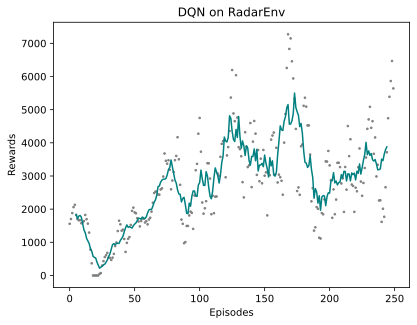

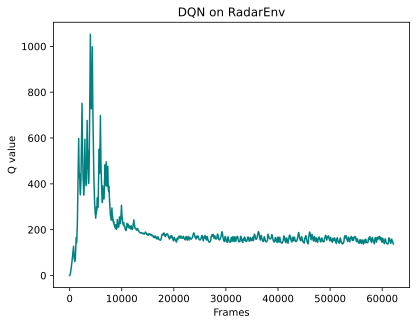

In [6]:
#绘图部分
%matplotlib inline
%config InlineBackend.figure_format='svg'      # 设置为矢量图格式


plt.scatter(episodes_list, mv_return,s=3,c='gray')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('DQN on {}'.format(env_name))

mean_return=[]
mean_interval=15#最近15步取平均 窗口大小必须奇数
mean_return=rl_utils.moving_average(return_list, mean_interval)
'''for i in range(0,len(return_list),mean_interval):
    mean_return.append(np.mean(return_list[i:i+mean_interval]))

plt.plot(episodes_list[::mean_interval], mean_return)'''
plt.plot(episodes_list[5:-5:1], mean_return[5:-5:1],c='teal')
plt.show()


if is_run!=2:
    max_q_value_list_copy=max_q_value_list.copy()
    
frames_list = list(range(len(max_q_value_list_copy)))
plt.plot(frames_list, max_q_value_list_copy,c='teal')
#plt.axhline(0, c='orange', ls='--')
#plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()




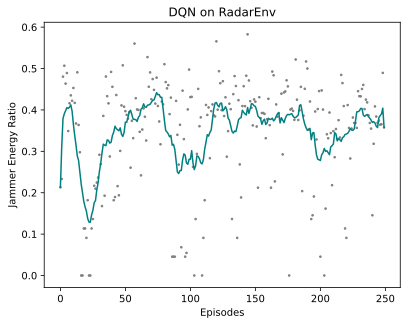

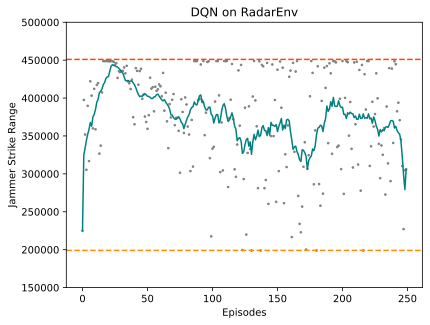

In [7]:
#评价指标
plt.scatter(episodes_list, energy_ratio,c='gray',s=3)
plt.xlabel('Episodes')
plt.ylabel('Jammer Energy Ratio')

mean_ratio=[]
mean_interval=5#最近5步取平均
'''for i in range(0,len(energy_ratio),mean_interval):
    mean_ratio.append(np.mean(energy_ratio[i:i+mean_interval]))

plt.scatter(episodes_list[::mean_interval], mean_ratio,c='red')'''

mean_interval=15#最近15步取平均 窗口大小必须奇数
mean_ratio=rl_utils.moving_average(energy_ratio, mean_interval)
plt.plot(episodes_list, mean_ratio,c='teal')

plt.title('DQN on {}'.format(env_name))
plt.show()



plt.scatter(episodes_list, strike_range,c='gray',s=3)
plt.xlabel('Episodes')
plt.ylabel('Jammer Strike Range')
plt.ylim(150E3,500E3)
mean_strike=[]
mean_interval=15#最近十步取平均
mean_strike=rl_utils.moving_average(strike_range, mean_interval)
'''for i in range(0,len(strike_range),mean_interval):
    mean_strike.append(np.mean(strike_range[i:i+mean_interval]))
'''
#plt.plot(episodes_list[::mean_interval], mean_strike)
plt.plot(episodes_list, mean_strike,c='teal')

plt.axhline(199E3, c='darkorange', ls='--')
plt.axhline(451E3, c='orangered', ls='--')

plt.title('DQN on {}'.format(env_name))
plt.show()

In [8]:
#重演最后一步

is_run=2

max_q_value_list = []
max_q_value = 0
radar_list,jetplane=env.Env_init()
state=env.get_current_state(radar_list,jetplane)#初始状态
done = False
while not done:
    action = agent.take_action(state,explore=False)#使用epsilon-greedy获得动作 拍扁的
                    
    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995  # 平滑处理
    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值'
    #核心动作：与环境交互
    next_state, reward, done = env.step(radar_list,jetplane,env.new_segment,env.dis2action(action))#
    
    state = next_state

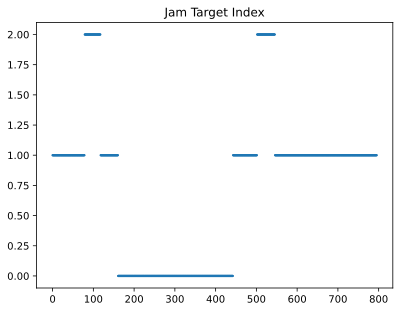

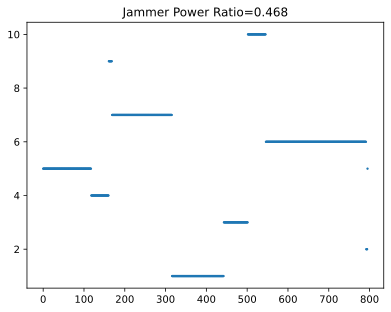

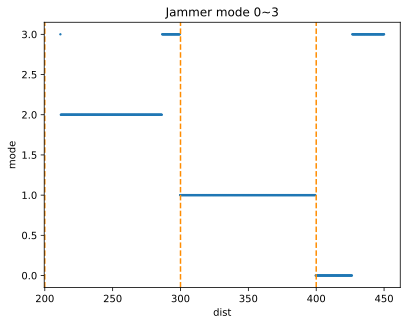

In [9]:
action_record=(jetplane.get_action_record())
dist=450-0.3*np.array(range(0,len(action_record)))

index_list=[action[0] for action in action_record]
mode_list=[action[2] for action in action_record]
P_list=[action[1] for action in action_record]


plt.title('Jam Target Index')
plt.scatter(range(0,len(mode_list)), index_list,s=2)
plt.show()

plt.title('Jammer Power Ratio={:.3f}'.format(((sum(P_list)/len(P_list))/env.Pn)))
plt.scatter(range(0,len(mode_list)), P_list,s=2)
plt.show()

plt.title('Jammer mode 0~3')
plt.ylabel('mode')
plt.xlabel('dist')

plt.scatter(dist, mode_list,s=2)
plt.axvline(400, c='darkorange', ls='--')
plt.axvline(300, c='darkorange', ls='--')
plt.axvline(200, c='darkorange', ls='--')
#plt.axvline(100, c='darkorange', ls='--')